In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


[2018-01-17 21:25:07,048] Making new env: CartPole-v0


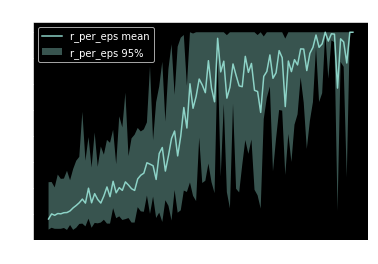

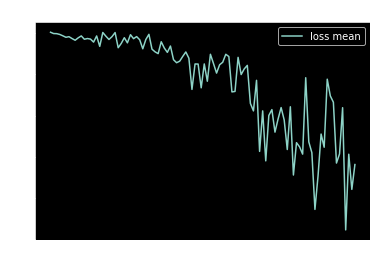

In [6]:
# Discrete task

from rl.algs import plotter
from rl.algs.pg import *

NUM_TRAIN_ITERS = 100
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 1000
env = Environment(max_episode_steps=MAX_STEPS_PER_EPISODE)
policy = Policy(env.ob_dim, env.ac_dim)

plt = plotter.Plotter()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  for name, metrics in m.items():
    plt.add_data(name, i, metrics)

plt.line_plot()
plt.render()


In [5]:
# Show an episode of the final policy
try:
  _ = env.sample_rollouts(policy.get_action, 1, render=True)
finally:
  env.env.render(close=True)


NameError: name 'env' is not defined

[2018-01-18 22:49:46,665] Making new env: RoboschoolInvertedPendulum-v1


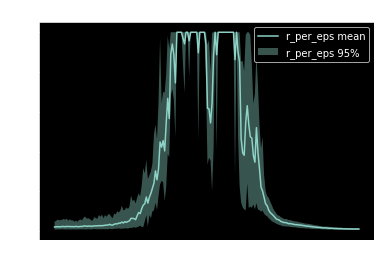

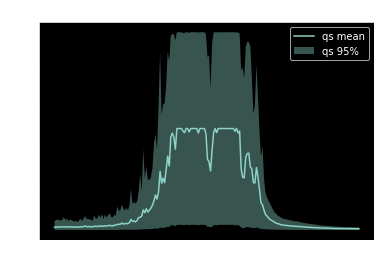

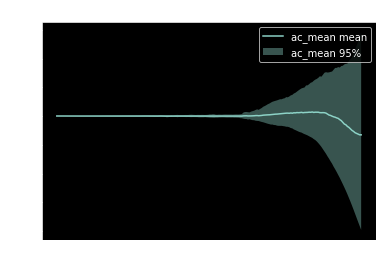

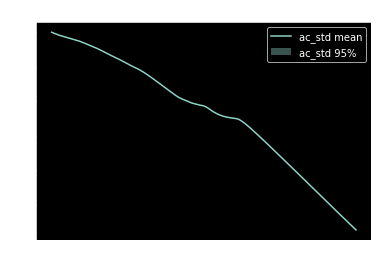

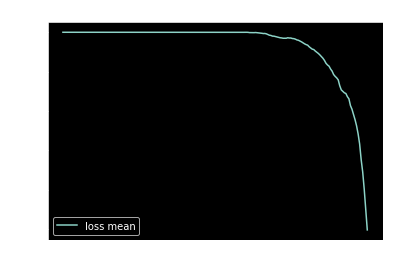

In [57]:
# Continuous task

import roboschool

from rl.algs import plotter
from rl.algs.pg import *

ENV_NAME = 'RoboschoolInvertedPendulum-v1'
#ENV_NAME = 'BipedalWalker-v2'
NUM_TRAIN_ITERS = 200
MAX_STEPS_PER_EPISODE = None  # default: None
STEPS_PER_BATCH = 5000
env = Environment(env_name=ENV_NAME,
                  max_episode_steps=MAX_STEPS_PER_EPISODE)
policy = ContinuousActionPolicy(env.ob_dim, env.ac_dim)
policy_snapshots = PolicySnapshots()

plt = plotter.Plotter()

for i in range(NUM_TRAIN_ITERS):
  eps_batch = env.sample_rollouts(policy.get_action, STEPS_PER_BATCH)
  m = policy.update(eps_batch)
  for name, metrics in m.items():
    plt.add_data(name, i, metrics)
  
  if i % 5 == 0:
    policy_snapshots.snapshot(i, policy)

plt.line_plot()
plt.render()


In [58]:
# Show an episode of a policy
def run_episode(policy):
  try:
    env = Environment(env_name=ENV_NAME,
                      max_episode_steps=MAX_STEPS_PER_EPISODE)
    _ = env.sample_rollouts(policy.get_action, 1, render=True)
  finally:
    env.env.render(close=True)
    del env

run_episode(policy_snapshots.get(90))


[2018-01-18 23:04:27,128] Making new env: RoboschoolInvertedPendulum-v1


In [9]:
# Scratchpad
import torch as th

mu = th.Tensor([0, 0.5, 1.0])
std = th.Tensor([1.0, 1.0, 1.0])

d = th.distributions.Normal(mu, std)
print(d)
a = th.Tensor([0, 0, 1.0])
th.exp(d.log_prob(a))

l = th.distributions.Normal(-0.2649, 1.1248).log_prob(-0.8086)
th.exp(th.Tensor([l]))



[4, 3, 2, 1]